In [2]:
from __future__ import division
import requests
import time as t
from mpl_toolkits.basemap import Basemap
from shapely.geometry import LineString
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle
from geojson import LineString, Feature, Point, FeatureCollection, dumps
import itertools
%matplotlib inline

# Env vars and functions

In [3]:
mapsApiKey = os.environ.get('GOOGLE_MAPS')

def decode(encoded):
    inv = 1.0 / 1e6
    decoded = []
    previous = [0,0]
    i = 0
    while i < len(encoded):
        ll = [0,0]
        for j in [0, 1]:
            shift = 0
            byte = 0x20
            while byte >= 0x20:
                byte = ord(encoded[i]) - 63
                i += 1
                ll[j] |= (byte & 0x1f) << shift
                shift += 5
            ll[j] = previous[j] + (~(ll[j] >> 1) if ll[j] & 1 else (ll[j] >> 1))
            previous[j] = ll[j]
        decoded.append([float('%.6f' % (ll[1] * inv)), float('%.6f' % (ll[0] * inv))])
    return decoded


def synthesize_gps(edges, shape, distribution="normal", stddev=0, uuid='999999'):
    
    jsonDict = {"uuid": uuid, "trace":[]}
    trueRouteCoords = []
    gpsRouteCoords = []
    coords = decode(shape)
    minCoordIndex = min([edge['end_shape_index'] for edge in edges])
    maxCoordIndex = max([edge['end_shape_index'] for edge in edges])
    if maxCoordIndex >= len(coords):
        return None, None
    sttm = t.time() - 86400   # yesterday
    
    for i, edge in enumerate(edges):

        dist = edge['length']
        speed = edge['speed']
        
        beginShapeIndex = edge['begin_shape_index']
        endShapeIndex = edge['end_shape_index']
        lon, lat = coords[endShapeIndex]
        

        if i == 0:
            st_lon, st_lat = coords[beginShapeIndex]
            trueRouteCoords.append([st_lon, st_lat])
        trueRouteCoords.append([lon, lat])
        
        if stddev > 0:
            avgLat = np.mean(np.array(coords)[:, 1])
            stddevLon = stddev / 111.111     # approx. 111.111 km per deg lon unless very close to the poles
            stddevLat = stddev / (111.111 * np.cos(avgLat))     # approx 111.111 km * cos(lat) per deg lat
            lon += np.random.normal(scale=stddevLon)
            lat += np.random.normal(scale=stddevLat)
        dur = dist / speed * 3600.0
        time = sttm + dur
        time = int(round(time))
        if i == 0:
            st_lon, st_lat = coords[beginShapeIndex]
            jsonDict["trace"].append({"lat":st_lat,"lon":st_lon,"time":sttm, "accuracy": min(5, stddev * 1e3)})
            gpsRouteCoords.append([st_lon, st_lat])
        jsonDict["trace"].append({"lat": lat,"lon":lon,"time":time, "accuracy": min(5, stddev * 1e3)})
        gpsRouteCoords.append([lon, lat])
        sttm = time
    
    geojson = FeatureCollection([
        Feature(geometry=LineString(trueRouteCoords), properties={"stroke": "#ff0000",
            "stroke-width": 2,
            "stroke-opacity": 1}),
        Feature(geometry=LineString(gpsRouteCoords), properties={"stroke": "#0000ff",
            "stroke-width": 2,
            "stroke-opacity": 1,
            "strokeColor": "#fff"})])
    return jsonDict, geojson


def get_route_shape(stLat, stLon, endLat, endLon):
    
    jsonDict = {"locations":[
        {"lat":stLat,"lon":stLon,"type":"break"},
        {"lat":endLat,"lon":endLon,"type":"break"}],
            "costing":"auto",
            "id":"my_work_route"}
    payload = {"json": json.dumps(jsonDict, separators=(',', ':'))}
    baseUrl = 'http://valhalla:8002/route'
#     route = requests.post(baseUrl, json=jsonDict)
    route = requests.get(baseUrl, params=payload)
    shape = route.json()['trip']['legs'][0]['shape']
    
    if route.status_code == 200:
        return shape, route.url
    else:
        print 'No shape returned'
        
        
def get_trace_attrs(shape):
    
    jsonDict = {
        "encoded_polyline": shape,
        "costing": "auto",
        "directions_options": {
            "units": "kilometers"
        },
        "shape_match": "edge_walk",
        "trace_options": {
            "turn_penalty_factor": 500
        }
    }
    payload = {"json": json.dumps(jsonDict, separators=(',',':'))}
    baseUrl = 'http://valhalla:8002/trace_attributes?'
    matched = requests.get(baseUrl, params=payload)
    edges = matched.json()['edges']
    
    return edges, matched.url


def format_edge_df(edges):
    
    dfEdges = pd.DataFrame(edges)
    dfEdges = dfEdges[['begin_shape_index','end_shape_index','length','speed','traffic_segments']]
    dfEdges['segment_id'] = dfEdges['traffic_segments'].apply(lambda x : str(x[0]['segment_id']) if type(x) is list else None)
    dfEdges['starts_segment'] = dfEdges['traffic_segments'].apply(lambda x : x[0]['starts_segment'] if type(x) is list else None)
    dfEdges['ends_segment'] = dfEdges['traffic_segments'].apply(lambda x : x[0]['starts_segment'] if type(x) is list else None)
    dfEdges['begin_percent'] = dfEdges['traffic_segments'].apply(lambda x : x[0]['begin_percent'] if type(x) is list else None)
    dfEdges['end_percent'] = dfEdges['traffic_segments'].apply(lambda x : x[0]['end_percent'] if type(x) is list else None)
    dfEdges.drop('traffic_segments', axis=1,inplace=True)
    
    return dfEdges


def get_reporter_segments(gpsTrace):
    
    baseUrl = 'http://reporter:8003/report'
    payload = {"json": json.dumps(gpsTrace,separators=(',',':'))}
    report = requests.get(baseUrl, params=payload)
    if report.status_code == 200:
        segments = report.json()['segments']
    else:
        print(report.reason)
        return None, report.url
    if len(segments) > 0:
        return segments, report.url
    else:
        return 0, report.url
    
        
def get_matches(segments, dfEdges):
    
    matches = dfEdges.copy()
    matches.loc[:, 'matched_segment_id'] = None
    matches.loc[:, 'matched_segment_sttm'] = None
    matches.loc[:, 'matched_segment_endtm'] = None
    for segment in segments:
        matches.loc[segment['begin_shape_index']:segment['end_shape_index'], 'matched_segment_id'] = str(segment['segment_id'])
        matches.loc[segment['begin_shape_index'], 'matched_segment_sttm'] = str(segment['start_time'])
        matches.loc[segment['end_shape_index'], 'matched_segment_endtm'] = str(segment['end_time'])
    matches.loc[:,'match'] = matches['segment_id'] == matches['matched_segment_id']
    score = np.sum(matches['match']) / len(matches[~pd.isnull(matches['segment_id'])])
    return matches, score


def get_POI_routes(locString, numResults, apiKey):
    
    url = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query={0}&radius={1}&key={2}'
    url = url.format("{0} point of interest".format(locString), 25000, apiKey)
    r = requests.get(url)
    POIs = [{x['name']:{"lat":x['geometry']['location']['lat'],"lon":x['geometry']['location']['lng']}} for x in r.json()['results']]
    routeList = list(itertools.combinations(POIs, 2))
    shuffle(routeList)
    numResults = min(len(routeList), numResults)
    routeList = routeList[:numResults]
    return routeList

# Open Traffic Reporter Validation Service 

### 1. Generate Random Routes from Google Maps API

In [24]:
routeList = get_POI_routes('San Francisco', 100, mapsApiKey)

In [18]:
routeList = [({"home":{"lat":37.8261, "lon": -122.25872}},{"work":{"lat":37.790168, "lon":-122.402264}})]

In [25]:
routeList

[({u'Coit Tower': {'lat': 37.8023949, 'lon': -122.4058222}},
  {u'California Academy of Sciences': {'lat': 37.76986459999999,
    'lon': -122.4660947}}),
 ({u'California Academy of Sciences': {'lat': 37.76986459999999,
    'lon': -122.4660947}},
  {u'PIER 39': {'lat': 37.808673, 'lon': -122.409821}}),
 ({u'Golden Gate Park': {'lat': 37.7694208, 'lon': -122.4862138}},
  {u'PIER 39': {'lat': 37.808673, 'lon': -122.409821}}),
 ({u'San Francisco Museum of Modern Art': {'lat': 37.7857182,
    'lon': -122.4010508}},
  {u'Lands End': {'lat': 37.7848836, 'lon': -122.50751}}),
 ({u'San Francisco Museum of Modern Art': {'lat': 37.7857182,
    'lon': -122.4010508}},
  {u'Lombard Street': {'lat': 37.802139, 'lon': -122.41874}}),
 ({u'Lombard Street': {'lat': 37.802139, 'lon': -122.41874}},
  {u'USS Pampanito': {'lat': 37.8099492, 'lon': -122.4164198}}),
 ({u'San Francisco Museum of Modern Art': {'lat': 37.7857182,
    'lon': -122.4010508}},
  {u'de Young Museum': {'lat': 37.771469, 'lon': -122.468

### 2. Iterate through each route, saving results to the ../data/ directory

In [26]:
df = pd.DataFrame(columns=['route','noise','score','route_url','trace_attr_url','reporter_url'])
outDfRow = -1

for i, rteCoords in enumerate(routeList):
    
    print i
    
    stName = 'home'
    endName = 'work'
    stLat = 37.8261
    stLon = -122.25872
    endLat = 37.790168
    endLon = -122.402264
    shape, routeUrl = get_route_shape(stLat, stLon, endLat, endLon)
    edges, traceAttrUrl = get_trace_attrs(shape)
    
    noiseLevels = np.linspace(0, 0.1, 11)
    scores = []
    
    for noise in noiseLevels:
        
        noise = round(noise,3)
        outDfRow += 1
        routeName = '{0}_to_{1}'.format(stName, endName)
        df.loc[outDfRow, ['route', 'noise','route_url','trace_attr_url']] = [routeName, noise, routeUrl, traceAttrUrl]
        dfEdges = format_edge_df(edges)
        jsonDict, geojson = synthesize_gps(edges, shape, stddev=noise)
        if jsonDict is None or geojson is None:
            msg = "Trace attributes tried to call more edges than are present in the route shape".format(
            routeName)
            df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
            continue
        segments, reportUrl = get_reporter_segments(jsonDict)
        if segments is None:
            continue
        elif segments == 0:
            msg = 'Reporter found 0 segments for {0} at noise level {1}'.format(
            routeName, noise)
            df.loc[outDfRow, ['score', 'reporter_url']] = [None, msg]
            continue
        matches, score = get_matches(segments, dfEdges)
        df.loc[outDfRow, ['score', 'reporter_url']] = [score, reportUrl]
        
        matches.to_csv(
            '../data/matches_{0}_to_{1}_w_{2}_km_noise.csv'.format(
                stName, endName, str(noise), index=False))
        with open('../data/trace_{0}_to_{1}_w_{2}_km_noise.geojson'.format(
            stName, endName, str(noise)), 'w+') as fp:
            json.dump(geojson, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### 3. Plot the results

In [21]:
df['score'] = df['score'].astype(float)

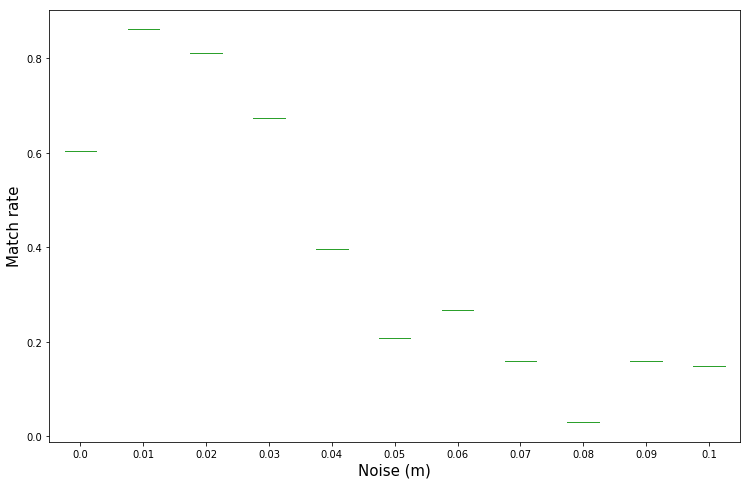

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
df.boxplot(column='score',by='noise', ax=ax, grid=False)
ax.set_xlabel('Noise (m)', fontsize=15)
ax.set_ylabel('Match rate', fontsize=15)
ax.set_title('')
fig.suptitle('')
fig.savefig('./../data/score_vs_noise.png')

In [23]:
df[df['noise']==0]

,route,noise,score,route_url,trace_attr_url,reporter_url
0,home_to_work,0,0.60396,http://valhalla:8002/route?json=%7B%22location...,http://valhalla:8002/trace_attributes?json=%7B...,http://reporter:8003/report?json=%7B%22uuid%22...


### 4. Save the scores

In [14]:
df.columns = [x.strip().replace(' ', '_') for x in df.columns]

In [15]:
df.to_csv('../data/master_scores.csv', index=False)